# Inspecting the Independent Variables

The goal is to select the best predictor variables, that is, those that most effectively discriminate among the vegetation types.

The data are examined for the three available label sets. Each set has a **different number of labels**.

> Note: `aspect` predictor has not been used as a predictor.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from matplotlib import pyplot as plt # type: ignore
from matplotlib.patches import Patch
from pathlib import Path
import numpy as np # type: ignore
import pandas as pd # type: ignore
import geopandas as gpd # type: ignore

In [ ]:
ROOT = r"D:\iranzo\doctorado_v2\classification"
# ROOT = r"C:\copia_seguridad\doctorado_v2\classification"

dataset = gpd.read_file(Path(ROOT, "results/dataset.gpkg"))
label_codes = pd.read_csv(Path(ROOT, "data/labels/label_codes.csv"))
# Exclude code_ifn to avoid deleting valid data with dropna
label_codes= label_codes.loc[:, label_codes.columns != 'code_ifn']
dataset = dataset.join(label_codes.set_index("code_v1"), on="ESPE")
# Remove Pinus uncinata, only 5 IFN labels inside landsat images
dataset = dataset.query("(code_v1_reclass != 5) & (code_v1_reclass != 15)")

In [3]:
graphics_path = Path(ROOT, "papers/RAQRS_journal/figures")

## Data Inspection

First, verify that the predictor variables are in a valid numerical format.

In [19]:
global_pred = ["aspect", "dem", "shadow", "slope", "acibasi"]
pred_vars = (
    dataset.columns.str.endswith("summer")
    | dataset.columns.str.endswith("spring")
    | dataset.columns.isin(global_pred)
)

In [20]:
dataset.loc[:, pred_vars].info()

<class 'pandas.core.frame.DataFrame'>
Index: 9991 entries, 0 to 9994
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   coastal_summer  9356 non-null   float64
 1   blue_summer     9366 non-null   float64
 2   green_summer    9398 non-null   float64
 3   red_summer      9398 non-null   float64
 4   nir_summer      9398 non-null   float64
 5   swir1_summer    9398 non-null   float64
 6   swir2_summer    9398 non-null   float64
 7   coastal_spring  8630 non-null   float64
 8   blue_spring     8643 non-null   float64
 9   green_spring    8681 non-null   float64
 10  red_spring      8679 non-null   float64
 11  nir_spring      8681 non-null   float64
 12  swir1_spring    8681 non-null   float64
 13  swir2_spring    8679 non-null   float64
 14  aspect          9991 non-null   float64
 15  dem             9991 non-null   int64  
 16  shadow          9991 non-null   int64  
 17  slope           9991 non-null   float6

All variables have the correct data type. However, some columns contain invalid values:

- **Landsat bands**: Negative values are associated with erroneous pixels.  
- **aspect**: Values below 0 are invalid.  
- **acibasi**: The value `-9999` corresponds to missing data.  
- **slope**: Negative values should not exist.  

For this reason, values below zero are transformed to `NaN`.  
This ensures that rows can be removed later if the corresponding dataset version makes use of the predictor variable.

In [21]:
dataset.loc[:, pred_vars].describe()

,coastal_summer,blue_summer,green_summer,red_summer,nir_summer,swir1_summer,swir2_summer,coastal_spring,blue_spring,green_spring,red_spring,nir_spring,swir1_spring,swir2_spring,aspect,dem,shadow,slope,acibasi
count,9356.000000,9366.000000,9398.000000,9398.000000,9398.000000,9398.00000,9398.000000,8630.000000,8643.000000,8681.000000,8679.000000,8681.000000,8681.000000,8679.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000
mean,845.968718,976.577190,1410.798077,1675.526154,2881.384267,3078.95185,2287.975963,757.057317,852.771205,1197.366562,1400.271288,2411.125111,2653.813054,1950.345333,89.700456,768.228606,168.196477,14.535919,-2017.771895
std,531.597914,617.606324,795.486521,1046.073290,759.137468,1402.04997,1295.379692,500.018243,531.153923,653.514449,809.379847,706.615429,1228.251009,1082.213337,1031.464532,344.964995,38.956873,9.450274,4014.267345
min,4.000000,8.000000,168.000000,65.000000,608.500000,451.00000,158.000000,9.000000,7.000000,-2651.500000,41.000000,110.000000,-6064.000000,48.500000,-19390.960938,108.000000,0.000000,-0.162517,-9999.000000
25%,344.000000,394.666667,646.375000,648.625000,2234.416667,1729.25000,1004.625000,347.000000,380.000000,584.000000,621.583333,1842.000000,1528.500000,927.250000,99.820225,424.000000,146.000000,7.088751,1.000000
50%,858.333333,989.500000,1386.166667,1651.916667,2810.916667,3032.00000,2269.428571,744.000000,848.000000,1201.333333,1433.000000,2306.000000,2651.000000,1909.000000,207.989044,784.000000,176.000000,13.777942,1.000000
75%,1268.750000,1476.000000,2089.500000,2596.000000,3453.916667,4337.23750,3428.000000,1057.383333,1223.000000,1717.000000,2069.750000,2925.000000,3689.333333,2842.250000,275.369781,1026.000000,193.000000,20.879910,1.000000
max,4912.000000,3582.000000,4195.666667,5029.333333,6148.000000,7219.00000,6690.000000,10906.000000,6915.000000,4335.000000,4572.000000,5507.000000,13335.000000,6363.000000,2401.559570,1847.000000,254.000000,77.194717,2.000000


In [22]:
# Make a copy to avoid modifying the original dataset in place
dat = dataset.copy()

# Replace values < 0 with 0 (nodata value) in the masked columns only
dat.loc[:, pred_vars] = (
    dat.loc[:, pred_vars]
    .where(dat.loc[:, pred_vars] >= 0, 0)
)

> **Note:** Some columns without negative values use 0 as their minimum because missing values (`NA`) were replaced with 0.

In [23]:
dat.loc[:, pred_vars].describe()

,coastal_summer,blue_summer,green_summer,red_summer,nir_summer,swir1_summer,swir2_summer,coastal_spring,blue_spring,green_spring,red_spring,nir_spring,swir1_spring,swir2_spring,aspect,dem,shadow,slope,acibasi
count,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000
mean,792.201314,915.486133,1327.062389,1576.077949,2710.364262,2896.205534,2152.176769,653.929001,737.714095,1040.635634,1216.390202,2094.983194,2306.457324,1694.229521,190.808143,768.228606,168.196477,14.535987,0.843159
std,554.285471,643.045467,840.458136,1089.067497,1002.823223,1542.200596,1367.733951,532.355188,573.536214,730.186324,890.367723,1047.000090,1451.456385,1204.713548,106.848945,344.964995,38.956873,9.450169,0.471535
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,108.000000,0.000000,0.000000,0.000000
25%,306.291667,350.666667,596.000000,573.000000,2163.166667,1594.625000,885.000000,213.000000,241.500000,441.500000,447.500000,1675.750000,1206.000000,678.250000,99.820225,424.000000,146.000000,7.088751,1.000000
50%,719.750000,825.666667,1183.333333,1364.000000,2721.000000,2785.333333,2006.000000,626.000000,694.500000,939.000000,1078.500000,2132.000000,2223.000000,1524.000000,207.989044,784.000000,176.000000,13.777942,1.000000
75%,1247.000000,1451.000000,2058.675000,2556.500000,3412.300000,4285.000000,3382.000000,1003.000000,1158.833333,1643.750000,1994.750000,2828.916667,3557.500000,2734.833333,275.369781,1026.000000,193.000000,20.879910,1.000000
max,4912.000000,3582.000000,4195.666667,5029.333333,6148.000000,7219.000000,6690.000000,10906.000000,6915.000000,4335.000000,4572.000000,5507.000000,13335.000000,6363.000000,2401.559570,1847.000000,254.000000,77.194717,2.000000


In [24]:
dat.loc[:, pred_vars].info()

<class 'pandas.core.frame.DataFrame'>
Index: 9991 entries, 0 to 9994
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   coastal_summer  9991 non-null   float64
 1   blue_summer     9991 non-null   float64
 2   green_summer    9991 non-null   float64
 3   red_summer      9991 non-null   float64
 4   nir_summer      9991 non-null   float64
 5   swir1_summer    9991 non-null   float64
 6   swir2_summer    9991 non-null   float64
 7   coastal_spring  9991 non-null   float64
 8   blue_spring     9991 non-null   float64
 9   green_spring    9991 non-null   float64
 10  red_spring      9991 non-null   float64
 11  nir_spring      9991 non-null   float64
 12  swir1_spring    9991 non-null   float64
 13  swir2_spring    9991 non-null   float64
 14  aspect          9991 non-null   float64
 15  dem             9991 non-null   int64  
 16  shadow          9991 non-null   int64  
 17  slope           9991 non-null   float6

In [25]:
# Remove columns with nodata values
dat = dat[(dat.loc[:, pred_vars] != 0).all(axis=1)]


In [26]:
dat.loc[:, pred_vars].describe()

,coastal_summer,blue_summer,green_summer,red_summer,nir_summer,swir1_summer,swir2_summer,coastal_spring,blue_spring,green_spring,red_spring,nir_spring,swir1_spring,swir2_spring,aspect,dem,shadow,slope,acibasi
count,6462.000000,6462.000000,6462.000000,6462.000000,6462.000000,6462.000000,6462.000000,6462.000000,6462.000000,6462.000000,6462.000000,6462.000000,6462.000000,6462.000000,6462.000000,6462.000000,6462.000000,6462.000000,6462.000000
mean,782.951667,900.616482,1295.835705,1518.604522,2796.239879,2906.099027,2093.531726,692.660731,768.503978,1064.090412,1227.120794,2278.878142,2426.287675,1725.949948,192.951696,829.114516,169.003405,15.292881,1.053544
std,527.645577,607.503460,762.865464,1003.383228,749.994055,1372.330864,1237.030911,526.144919,543.890954,630.494461,776.396638,667.859641,1193.714109,1024.881717,100.763295,306.954538,38.679740,9.029982,0.225133
min,11.000000,10.000000,168.000000,65.000000,608.500000,451.000000,158.000000,9.000000,25.000000,66.333333,41.000000,170.000000,130.666667,48.500000,0.000100,108.000000,1.000000,0.006603,1.000000
25%,327.233333,377.541667,633.000000,622.000000,2186.375000,1680.083333,956.812500,283.000000,316.125000,522.000000,552.750000,1783.125000,1401.250000,828.000000,104.415398,592.000000,146.000000,8.432046,1.000000
50%,578.750000,648.833333,982.500000,1140.500000,2636.750000,2539.875000,1766.250000,607.000000,660.500000,889.000000,990.750000,2107.833333,2142.250000,1453.000000,207.911850,874.000000,175.000000,14.730375,1.000000
75%,1231.916667,1419.750000,1957.500000,2441.812500,3358.937500,4213.583333,3239.875000,998.000000,1132.000000,1545.000000,1877.000000,2726.500000,3454.750000,2600.000000,275.261642,1041.000000,195.000000,21.445545,1.000000
max,4912.000000,3582.000000,4195.666667,5029.333333,6148.000000,7138.000000,6115.000000,10906.000000,6915.000000,4335.000000,4572.000000,5507.000000,13335.000000,6363.000000,405.660309,1827.000000,254.000000,77.194717,2.000000


To obtain a more balanced dataset, most of the labels corresponding to sparse vegetation were removed, leaving a number of cases similar to that of the second most frequent label.

In [27]:
def bg_undersampling(df):
    """Perform a reduction in the very high bare ground number of labels"""
    X = df.drop(columns=['ESPE_rc'])
    y = df['ESPE_rc']

    # Find the sparse vegetation class
    max_clss = y.value_counts().idxmax()
    # Define the undersampler
    rus = RandomUnderSampler(
        sampling_strategy={max_clss: 800},
        random_state=42
    )

    # Apply undersampling
    X_resampled, y_resampled = rus.fit_resample(X, y)

    # Create new dataframe. This is mandatory to remove NA values in each
    # predictor set iteration and remove the ESPE codes related to them
    dataset = pd.concat([
        X_resampled.reset_index(drop=True),
        y_resampled.reset_index(drop=True)],
        axis=1
    )

    return dataset

dat = bg_undersampling(dat)

In [28]:
dat.loc[:, pred_vars].info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4433 entries, 0 to 4432
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   blue_summer         4433 non-null   float64 
 1   green_summer        4433 non-null   float64 
 2   red_summer          4433 non-null   float64 
 3   nir_summer          4433 non-null   float64 
 4   swir1_summer        4433 non-null   float64 
 5   swir2_summer        4433 non-null   float64 
 6   coastal_spring      4433 non-null   float64 
 7   blue_spring         4433 non-null   float64 
 8   green_spring        4433 non-null   float64 
 9   red_spring          4433 non-null   float64 
 10  nir_spring          4433 non-null   float64 
 11  swir1_spring        4433 non-null   float64 
 12  swir2_spring        4433 non-null   float64 
 13  coastal_summerlong  4433 non-null   float64 
 14  dem                 4433 non-null   int64   
 15  shadow              4433 non-n

### Create NDVI

In [29]:
def ndvi(df, suffix):
    numerator = df[f"nir_{suffix}"] - df[f"red_{suffix}"]
    denominator = df[f"nir_{suffix}"] + df[f"red_{suffix}"]
    return numerator / denominator

dat["NDVI_summer"] = ndvi(dat, "summer")
dat["NDVI_spring"] = ndvi(dat, "spring")
dat["NDVI_summerlong"] = ndvi(dat, "summerlong")

## Versions

There are three different training datasets, or versions of the original dataset.

In [30]:
dat_queries = {1: "(source == 'Digitized') | (source == 'SIOSE')"}
dat_queries[2] = f"(FCC > 20) & (Ocu1 > 4) | ({dat_queries[1]})"
dat_queries[3] = f"(FCC > 20) & (Ocu1 > 6) | ({dat_queries[1]})"

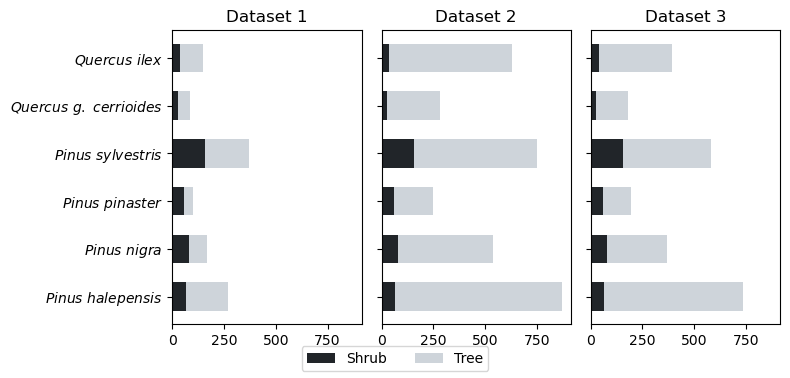

In [31]:
# Count of each class
bbox_label_groups = {
    r"$\it{Pinus\ halepensis}$": [1, 11],
    r"$\it{Pinus\ nigra}$": [2, 12],
    r"$\it{Pinus\ pinaster}$": [3, 13],
    r"$\it{Pinus\ sylvestris}$": [4, 14],
    # r"$\it{Pinus\ uncinata}$": [5],
    r"$\it{Quercus}\ g.\ \it{cerrioides}$": [6, 16],
    r"$\it{Quercus\ ilex}$": [7, 17]
}

species = list(bbox_label_groups.keys())
tree_groups = [g[0] for g in bbox_label_groups.values()]
shrub_groups = [g[1] for g in bbox_label_groups.values()]

# Dictionary to store groups which have been the bar levels
count_dict = {
    "Shrub": {"group": shrub_groups, "color": "#212529"},
    "Tree": {"group": tree_groups, "color": "#ced4da"}
}

height = 0.6  # the thickness of the bars

# One plot by dataset version
fig, axs = plt.subplots(1, 3, figsize=(8, 4), sharey=True, sharex=True)

for v in range(3):

    dat_i = dat.query(dat_queries[v+1])
    # Spaces between bars
    left = np.zeros(len(species))

    for i, (lab, lab_group) in enumerate(count_dict.items()):

        group, color = lab_group.values()
        query = f"code_v1_reclass in [{','.join([str(v) for v in group])}]"
        d = dat_i.query(query)
        d_group = d.groupby(["code_v1_reclass"]).count()["ESPE"].sort_index()
        sp_count = d_group.values

        axs[v].barh(species, sp_count, height=height, color=color, left=left)
        # Add the next group of bars on top of the last ones
        left += sp_count

        axs[v].set_title(f"Dataset {v+1}")

# Create empty lists to store legend handles (colored patches) and labels
leg_handles, leg_labels = [], []

# Loop over category names and their associated colors
for label, l_dict in count_dict.items():

    # Create a dummy colored patch for the legend
    # (no need to actually plot bars — just create a representative box)
    leg_handles.append(Patch(facecolor=l_dict["color"], label=label))

    # Store the corresponding label for later use
    leg_labels.append(label)

# Create a global legend at the bottom of the figure
# - `leg_handles`: list of patches to show in the legend
# - `leg_labels`: corresponding text labels
# - `loc='best'`: place legend in the best position according to pyplot
# - `ncol=1`: ensure vertical layout
# - `title=''`: no legend title
fig.legend(leg_handles, leg_labels, loc='lower center', ncol=2, title='')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# plt.savefig(Path(graphics_path, f"labels_distribution.svg"))


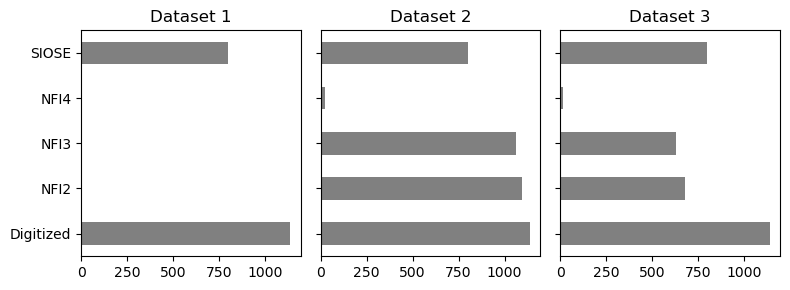

In [17]:
# One plot by dataset version
fig, axs = plt.subplots(1, 3, figsize=(8, 3), sharey=True, sharex=True)

for v in range(1, 4):
    dat_i = dat.query(dat_queries[v])
    # Counting the species values giving the label source
    grpd = dat_i.groupby(["source"]).count()["ESPE"]
    # Temporal fix to the fact that dataset 1 only contains 2 labels
    if v == 1:
        new_rows = pd.Series([0] * 3, index=[f"NFI{i}" for i in range(2,5)])
        grpd = pd.concat([grpd, new_rows])
    
    (grpd
        .sort_index()
        .plot(kind='barh', color="grey", ax=axs[v-1], title=f"Dataset {v}")
    )

fig.tight_layout()

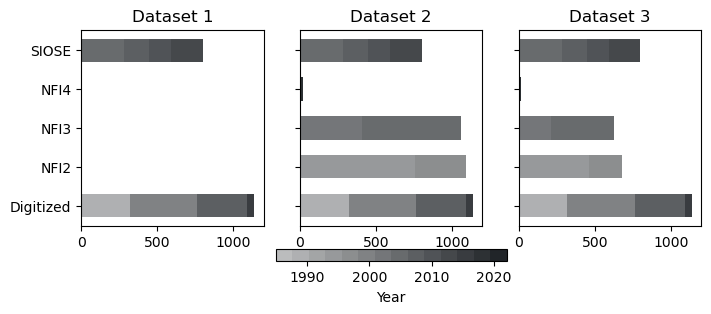

In [32]:
import matplotlib.colors as mcolors

# One plot by dataset version
fig, axs = plt.subplots(1, 3, figsize=(8, 3), sharey=True, sharex=True)

dataset_sources = pd.unique(dat["source"])
years = sorted(pd.unique(dat["YEAR"]))
height = 0.6  # the thickness of the bars

# Create a colormap from grayscale colors
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_grey",
    ["#bbbcbd", "#212529"],
    len(years)
)
colors = [cmap(i) for i in range(cmap.N)]
year_to_color = {year: colors[i] for i, year in enumerate(years)}

for v in range(1, 4):
    left = np.zeros(len(dataset_sources))

    dat_i = dat.query(dat_queries[v])

    for i, year in enumerate(years):

        if year not in pd.unique(dat_i["YEAR"]):
            continue
        query = f"YEAR == {year}"
        d = dat_i.query(query)
        d_group = d.groupby(["source"]).count()["ESPE"]
        # Not all the years contain the same sources
        # Add the current year values to a pandas of the sources with join
        temp_pd = pd.concat([
            pd.Series([0]*len(dataset_sources), index=dataset_sources),
            pd.Series(d_group.values, index=d_group.index, name="data"),
        ], axis=1).fillna(0).sort_index()
        axs[v-1].barh(
            temp_pd.index,
            temp_pd["data"],
            height=height,
            color=year_to_color[year],
            left=left)
        # Add the next group of bars on top of the last ones
        left += temp_pd["data"]

        axs[v-1].set_title(f"Dataset {v}")
        axs[v-1].set_xlim((0, 1200))

# ---- Gradient Legend ----
# Normalize years to the range [0,1] for color mapping
norm = mcolors.Normalize(vmin=min(years), vmax=max(years))

# Add a colorbar to illustrate the gradient
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # only needed for matplotlib < 3.2

cbar = fig.colorbar(
    sm,
    ax=axs,
    orientation="horizontal",
    fraction=0.05,
    pad=0.1
)
cbar.set_label("Year")
# fig.tight_layout(rect=[0, 0.02, 1, 0.95])
# plt.savefig(Path(graphics_path, f"dataset_versions.svg"))


## Outliers

After generating a Cleveland dot plot (Cleveland, 1993), the following anomalous values were observed:

- **NDVI**: Values below 0, typically associated with water, snow, clouds, or certain artificial surfaces.  
- **SWIR1 (spring)**: Values very close to or greater than 1, likely due to Landsat band errors or cloud contamination.  

All other values appear to fall within the expected ranges and accurately represent the land cover types.


In [36]:
# Boxplots of predictor variables
lcols = (
    dat.columns[dat.columns.str.endswith("summer")].to_list() +
    dat.columns[dat.columns.str.endswith("spring")].to_list()
)
gcols = ['dem', 'shadow', 'slope', 'acibasi']

def print_dotplot(df, sorted_idx, col, ax, legend_groups):

    for group_name, group_dict in legend_groups.items():
        
        sorted_values = df.iloc[sorted_idx].query(group_dict["query"])[col]
    
        # Cleveland dotplot
        ax.plot(
            sorted_values,
            range(len(sorted_values)),
            "o",
            color=group_dict["color"])
    
    # Formatting
    ax.set_xlabel("Value")
    ax.set_ylabel("Observation (sorted index)")
    ax.grid(True, axis="x", linestyle="--", alpha=0.6)
    ax.set_title(col)

def dotplot_figure(df, version, lcols, gcols, nrows, ncols, output_path=None):

    fig, axs = plt.subplots(nrows, ncols, figsize = (10,10), sharey=True)

    # Transform landsat bands to reflectance
    pattern =  fr'^(?!NDVI_).*(spring|summer)$'
    target_bands = df.columns.str.contains(pattern)
    df_ref = df.copy()
    df_ref.loc[:, target_bands] = df_ref.loc[:, target_bands] / 10000

    df_v = df_ref.query(dat_queries[version])
    # Select the first column to plot
    values = df_v["dem"]
    # Sort values for readability
    sorted_idx = values.argsort()

    # Store plot styles to create the graph legend
    leg_groups = {
        "Sparse vegetation": {"color": "#ACACAC", "query": "ESPE_rc == 20"},
        "Tree": {"color": "#666B6F", "query": "ESPE_rc < 10"},
        "Shrub": {"color": "#212529", "query": "(ESPE_rc > 10) and (ESPE_rc < 20)"}
    }

    for n, df_col in enumerate(lcols + gcols):

        # Integer division
        row = n // ncols
        # Division Remainder
        col = n % ncols

        print_dotplot(df_v, sorted_idx, df_col, axs[row, col], leg_groups)

    # Create a global legend
    leg_handles, leg_labels = [], []
    for label, properties in leg_groups.items():
        leg_handles.append(
            axs[0, 0].plot(
                [], [],
                # marker="o",
                color=properties['color'],
                linewidth=2,
                label=label
            )[0]
        )
        leg_labels.append(label)

    # Add global legend
    fig.legend(leg_handles, leg_labels, loc='lower center', ncol=8, title='')
    # Adjust layout to fit global legend
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    if output_path is not None:
        plt.savefig(output_path)

C:\Users\usuario\AppData\Local\Temp\ipykernel_19812\1013967191.py:33: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  target_bands = df.columns.str.contains(pattern)


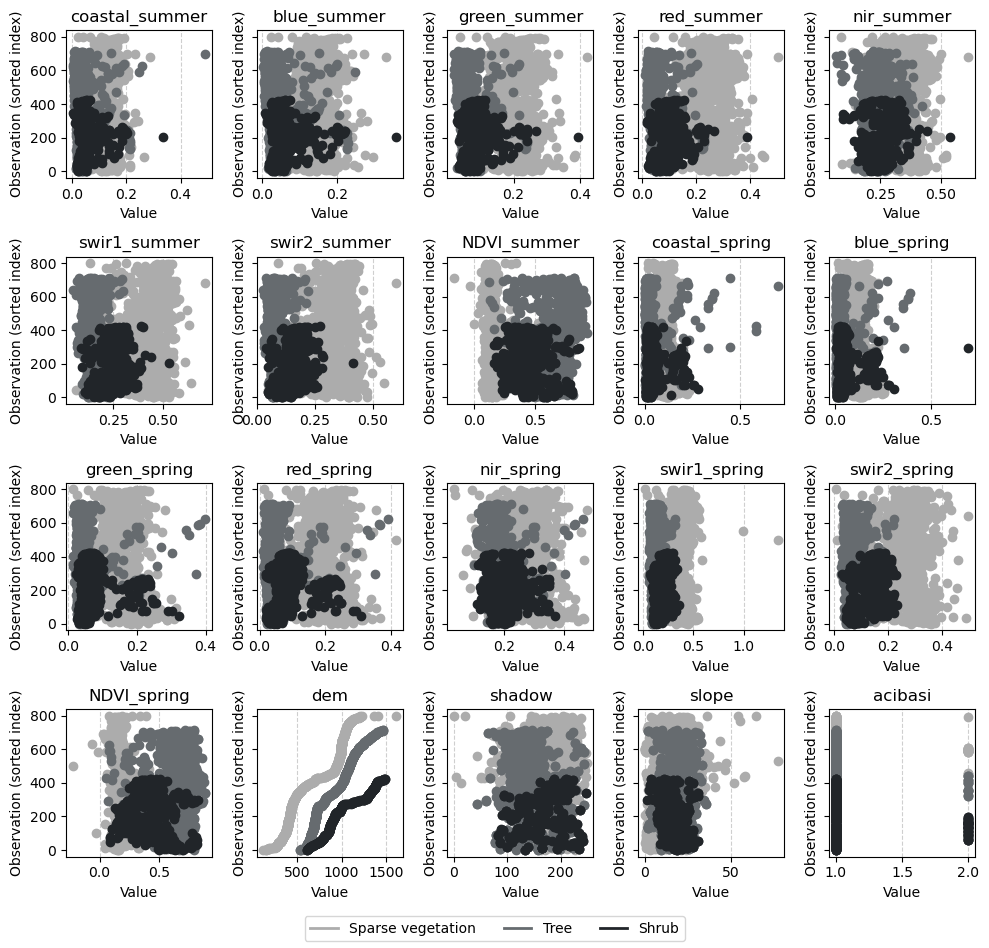

In [37]:
nrows = 4
ncols = 5

outpath = Path(graphics_path, "cleveland_plot.svg")
dotplot_figure(dat, 1, lcols, gcols, nrows, ncols, outpath)

In [38]:
def drop_outliers(df):
    target = df.copy()
    # Likely water, snow, clouds, or some artificial surfaces.
    target.query("(NDVI_summer > 0) and (NDVI_spring > 0)", inplace=True)
    # Likely clouds or Landsat 7 errors
    target.query("swir1_spring < 9000", inplace=True)
    return target

dat[["NDVI_summer", "NDVI_spring", "swir1_spring"]].describe()

,NDVI_summer,NDVI_spring,swir1_spring
count,4433.000000,4433.000000,4433.000000
mean,0.465351,0.444636,1930.905959
std,0.204360,0.185816,977.143727
min,-0.160187,-0.227025,181.000000
25%,0.312997,0.305206,1233.000000
50%,0.489576,0.461305,1661.000000
75%,0.619689,0.583333,2322.000000
max,0.943844,0.889621,13335.000000


In [39]:
drop_outliers(dat)[["NDVI_summer", "NDVI_spring", "swir1_spring"]].describe()

,NDVI_summer,NDVI_spring,swir1_spring
count,4426.000000,4426.000000,4426.000000
mean,0.466009,0.445296,1925.793903
std,0.203804,0.185132,954.044049
min,0.001411,0.027100,181.000000
25%,0.315384,0.305795,1233.000000
50%,0.489763,0.461957,1659.750000
75%,0.620024,0.583624,2318.750000
max,0.943844,0.889621,6216.000000


In [40]:
dat_without_out = drop_outliers(dat)

## Behavior of Predictor Variables

For each dataset version, an analysis of the predictor variables was carried out. All three versions of the dataset exhibit an imbalanced sample distribution.


### Landsat bands

In [86]:
def ref_plot(df, version):
    # Transform values to reflectance in order to get
    # a better representation of the spec. sign.
    lcols = (
        df.columns.str.endswith("summer")
        | df.columns.str.endswith("spring")
    )

    dat_ref = df.copy().query(dat_queries[version])
    dat_ref.loc[:, lcols] = dat_ref.loc[:, lcols] / 10000

    # Compute plots by tree, shrub and bare ground
    spectral_sign_splits = {
        'Trees': [1, 2, 3, 4, 5, 6, 7],
        'Shrubs': [11, 12, 13, 14, 16, 17],
        'Bare soil': [20]
    }

    # Three rows (summer, spring and summer long) and three cols
    # (three spectral signature split types).
    fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(13,8))

    veg_styles = {
        # Obligate seeders
        r"$\it{Pinus\ halepensis}$": {'color': "#525252", 'linestyle': '-'},
        r"$\it{Pinus\ pinaster}$": {'color': "#969696", 'linestyle': '-'},
        # Passive defense systems
        r"$\it{Pinus\ nigra}$": {'color': "#525252", 'linestyle': '-.'},
        r"$\it{Pinus\ sylvestris}$": {'color': "#969696", 'linestyle': '-.'},
        # 'Pinus uncinata': {'color': "#cccccc", 'linestyle': '-.'},
        # Obligate resprouters
        r"$\it{Quercus}\ g.\ \it{cerrioides}$": {'color': "#525252", 'linestyle': '--'},
        r"$\it{Quercus\ ilex}$": {'color': "#969696", 'linestyle': '--'}
    }

    shrub_styles = veg_styles.copy()
    # Remove the Pinus uncinata
    # del shrub_styles['Pinus uncinata']

    bare_g_style = {
        "Sparse vegetation": {'color': "#212529", "linestyle": "-"}
    }

    for i, (ss_name, ss_codes) in enumerate(spectral_sign_splits.items()):

        if len(ss_codes) > 1:
            q = f"code_v1_reclass in ({",".join(map(str, ss_codes))})"
        else:
            q = f"code_v1_reclass == 20"

        if ss_name == "Trees":
            styles = veg_styles
        elif ss_name == "Shrubs":
            styles = shrub_styles
        else:
            styles = bare_g_style

        df = dat_ref.query(q)

        # Summerlong values are the same as summer
        for z, season in enumerate(["spring", "summer"]):

            pattern =  fr'^(?!NDVI_).*{season}$'

            plot_cols = df.columns[df.columns.str.contains(pattern)].to_list()
            grp = df[
                plot_cols + ["label_reclass"]].groupby('label_reclass').mean()

            # Extract band names without season suffix
            plot_cols = [c.split("_")[0] for c in plot_cols]
            for e, (label_values, row) in enumerate(grp.iterrows()):

                axs[z, i].plot(
                    plot_cols,
                    row,
                    # marker="o",
                    label=label_values,
                    color= [d['color'] for d in styles.values()][e],
                    linestyle = [d['linestyle'] for d in styles.values()][e]
                )

                axs[z, i].set_xlabel("Wavelength")
                axs[z, i].set_ylabel(f"Ref. {season}")
                axs[z, i].grid(True)


    # Create a global legend
    leg_handles, leg_labels = [], []
    for label, properties in {**veg_styles, **bare_g_style}.items():
        leg_handles.append(
            axs[0, 0].plot(
                [], [],
                # marker="o",
                color=properties['color'],
                linestyle=properties['linestyle'],
                label=label
            )[0]
        )
        leg_labels.append(label)

    # Add global legend
    fig.legend(leg_handles, leg_labels, loc='lower center', ncol=8, title='')
    # Adjust layout to fit global legend
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

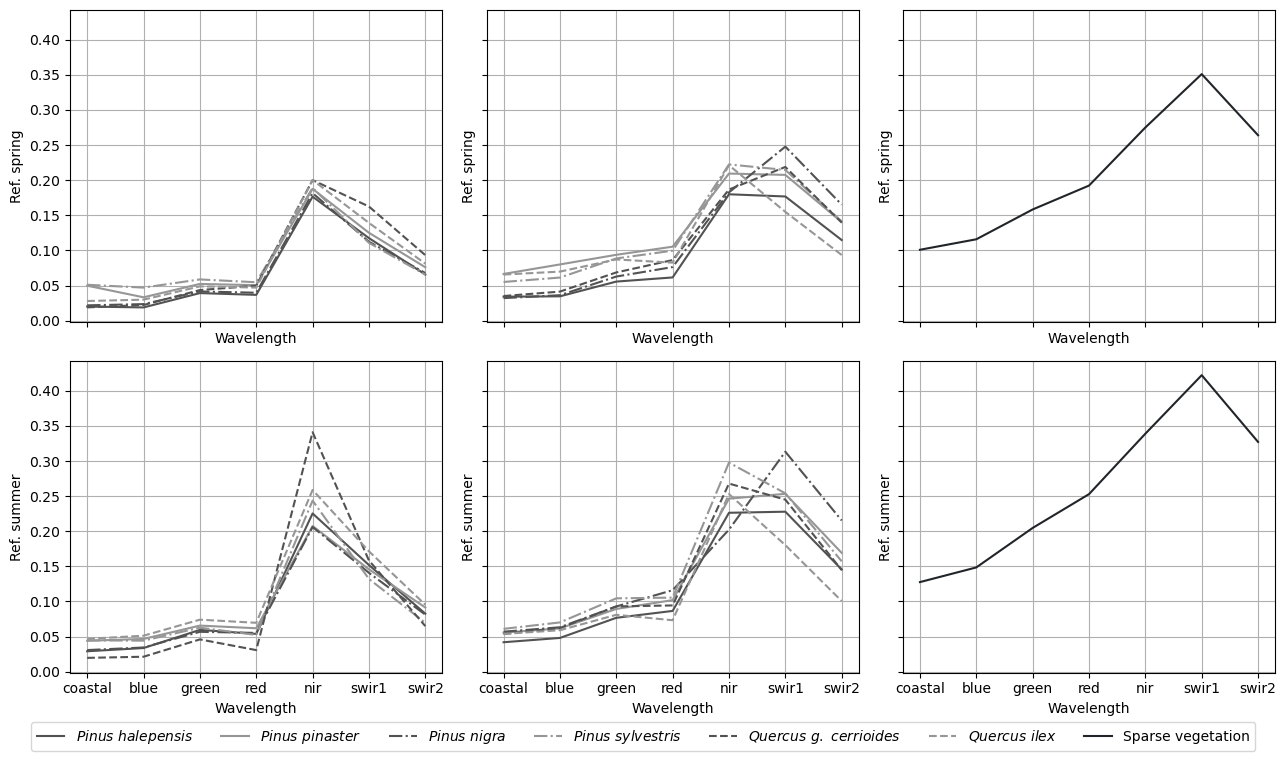

In [87]:
ref_plot(dat, 1)

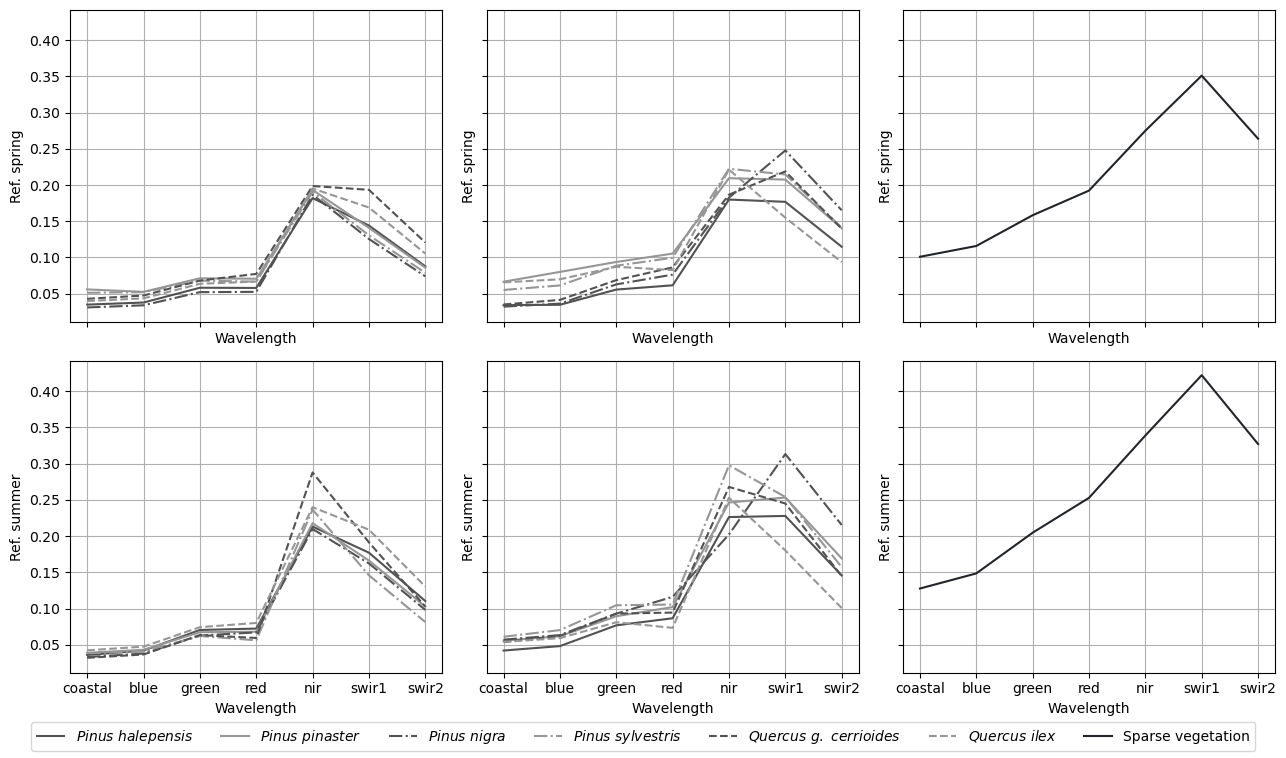

In [88]:
ref_plot(dat, 2)

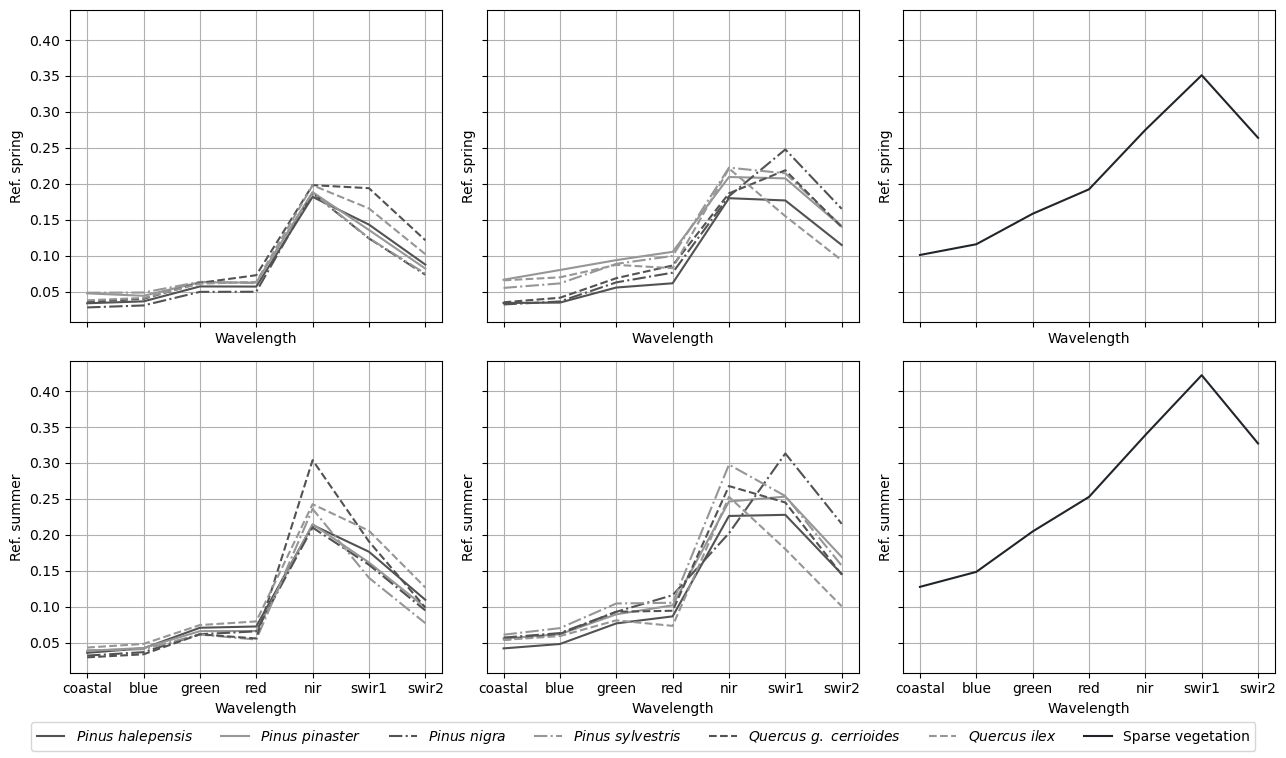

In [89]:
ref_plot(dat, 3)

#### Spectral signatures miniplots

Generate small plots showing the spectral signature of a species and its shrubland.


In [66]:
def ref_mini_plot(df, tree, shrub, outpath = None):
    # Transform values to reflectance in order to get
    # a better representation of the spec. sign.
    lcols = (
        df.columns.str.endswith("summer")
        | df.columns.str.endswith("spring")
    )
    dat_ref = df.copy()
    dat_ref.loc[:, lcols] = df.loc[:, lcols] / 10000

    # Three rows (summer, spring and summer long) and three cols
    # (three spectral signature split types).
    fig, ax = plt.subplots(1, 1, figsize=(3,3))

    # Summer signature
    pattern =  fr'^(?!NDVI_).*summer$'
    plot_cols = dat_ref.columns[dat_ref.columns.str.contains(pattern)]
    plot_reduced_cols = plot_cols.to_list() + ["label_reclass"]
    
    # Tree spectre
    q = f"code_v1_reclass == {tree}"
    dat_ref_tree = dat_ref.query(q)
    grp = dat_ref_tree[plot_reduced_cols].groupby('label_reclass').mean()
    tree_vals = grp.iloc[0, :].values
    # Shrub spectre
    q = f"code_v1_reclass == {shrub}"
    dat_ref_shrub = dat_ref.query(q)
    grp = dat_ref_shrub[plot_reduced_cols].groupby('label_reclass').mean()
    shrub_vals = grp.iloc[0,:].values

    # Extract band names without season suffix
    plot_col_names = ["C", "B", "G", "R", "N", "SW1", "SW2"]

    ax.plot(
        plot_col_names,
        tree_vals,
        marker="o",
        linestyle="-",
        label="Tree",
        color= "#525252"
    )

    ax.plot(
        plot_col_names,
        shrub_vals,
        marker="o",
        label="Shrub",
        linestyle="--",
        color= "#525252"
    )

    # ax.set_xlabel("Wavelength")
    ax.set_ylabel("Average summer reflectance")
    ax.grid(True)
    ax.set_ylim(0, .4)
    ax.set_yticks((0, .1, .2, .3, .4))

    # Create a global legend
    leg_handles, leg_labels = [], []
    for label, linestyle in zip(["Tree", "Shrub"], ["-", "--"]):
        leg_handles.append(
            ax.plot(
                [], [],
                # marker="o",
                color="#525252",
                linestyle=linestyle,
                label=label
            )[0]
        )
        leg_labels.append(label)

    # Add global legend
    # fig.legend(leg_handles, leg_labels, loc='lower center', ncol=8, title='')
    # Adjust layout to fit global legend
    # fig.tight_layout(rect=[0, 0.04, 1, 0.95])
    fig.tight_layout()

    if outpath is not None:
        plt.savefig(Path(outpath, f"ref_miniplot_{tree}_vs_{shrub}.svg"))

In [69]:
# for i in [1, 2, 3, 4, 6, 7]:
    # ref_mini_plot(dat_without_out.query(dat_queries[1]), i, i+10, graphics_path)

### Global Predictors and Indices

In [90]:
nrows = 2
ncols = 3

# Function to color boxplot
def set_box_colors(bp, colors):
    for patch in bp['boxes']:
        patch.set(color=colors["box"])
    for whisker in bp['whiskers']:
        whisker.set(color=colors["whisker"], linewidth=1.5)
    for cap in bp['caps']:
        cap.set(color=colors["cap"], linewidth=1.5)
    for median in bp['medians']:
        median.set(color=colors["median"], linewidth=2)
    for flier in bp['fliers']:
        flier.set(
            markerfacecolor=colors["flier"],
            markeredgecolor=colors["flier"],
            marker='o',
            alpha=1
        )

def create_boxplot(df, pred_vars, ncols, nrows):

    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10), sharey=True)

    bbox_label_groups = {
        r"$\it{Pinus\ halepensis}$": [1, 11],
        r"$\it{Pinus\ nigra}$": [2, 12],
        r"$\it{Pinus\ pinaster}$": [3, 13],
        r"$\it{Pinus\ sylvestris}$": [4, 14],
        # r"$\it{Pinus\ uncinata}$": [5],
        r"$\it{Quercus}\ g.\ \it{cerrioides}$": [6, 16],
        r"$\it{Quercus\ ilex}$": [7, 17],
        r"$\it{Sparse\ vegetation}$": [20]
    }

    box_width = 0.3

    # Custom colors for box1
    shrub_boxs = {
        "box": "#969696",
        "whisker": "#969696",
        "cap": "#969696",
        "median": "#969696",
        "flier": "#969696"
    }

    # Custom colors for box2
    veg_boxs = {
        "box": "#212529",
        "whisker": "#212529",
        "cap": "#212529",
        "median": "#212529",
        "flier": "#212529"
    }

    for n, var in enumerate(pred_vars):

        # Integer division
        row = n // ncols
        # Division Remainder
        col = n % ncols

        # Split between shrub and trees (and sparse veg)
        for i, (_, lbl_groups) in enumerate(bbox_label_groups.items()):
            
            query_str = "code_v1_reclass == {}"
            
            if len(lbl_groups) == 1:
                data = df.query(query_str.format(lbl_groups[0]))[var]

                box = axs[row, col].boxplot(
                    data,
                    positions=[i+1],
                    widths=box_width,
                    vert=False
                    # orientation="horizontal"
                )
                
                set_box_colors(box, veg_boxs)

            else:
                data = df.query(query_str.format(lbl_groups[0]))[var]
                # Shift the two boxplots slightly left and right of
                # the same group to plot both together
                box1 = axs[row, col].boxplot(
                    data,
                    positions=[(i + 1) - box_width / 2],
                    widths=box_width,
                    vert=False
                    # orientation="horizontal"
                )

                data = df.query(query_str.format(lbl_groups[1]))[var]
                box2 = axs[row, col].boxplot(
                    data,
                    positions=[(i+1) + box_width / 2], 
                    widths=box_width,
                    vert=False
                    # orientation="horizontal"
                )

                # Apply colors
                set_box_colors(box1, veg_boxs)
                set_box_colors(box2, shrub_boxs)

        # Now only set one xtick at the group position
        axs[row, col].set_yticks([z + 1 for z in range(len(bbox_label_groups))])
        axs[row, col].set_yticklabels(bbox_label_groups.keys())
        axs[row, col].grid(True)
        axs[row, col].set_title(var)


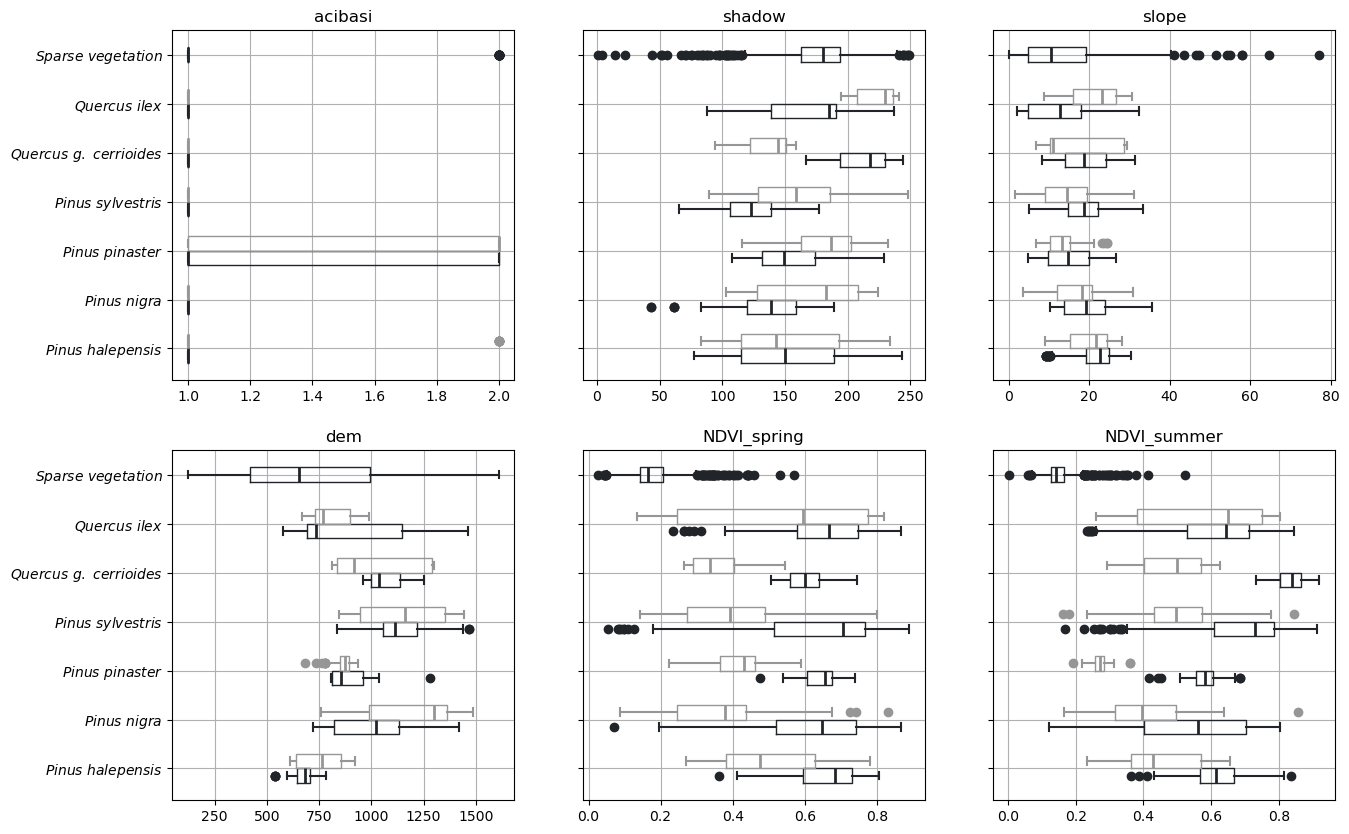

In [91]:
bbox_vars = ["acibasi", "shadow", "slope", "dem", "NDVI_spring", "NDVI_summer"]

create_boxplot(dat_without_out.query(dat_queries[1]), bbox_vars, ncols, nrows)

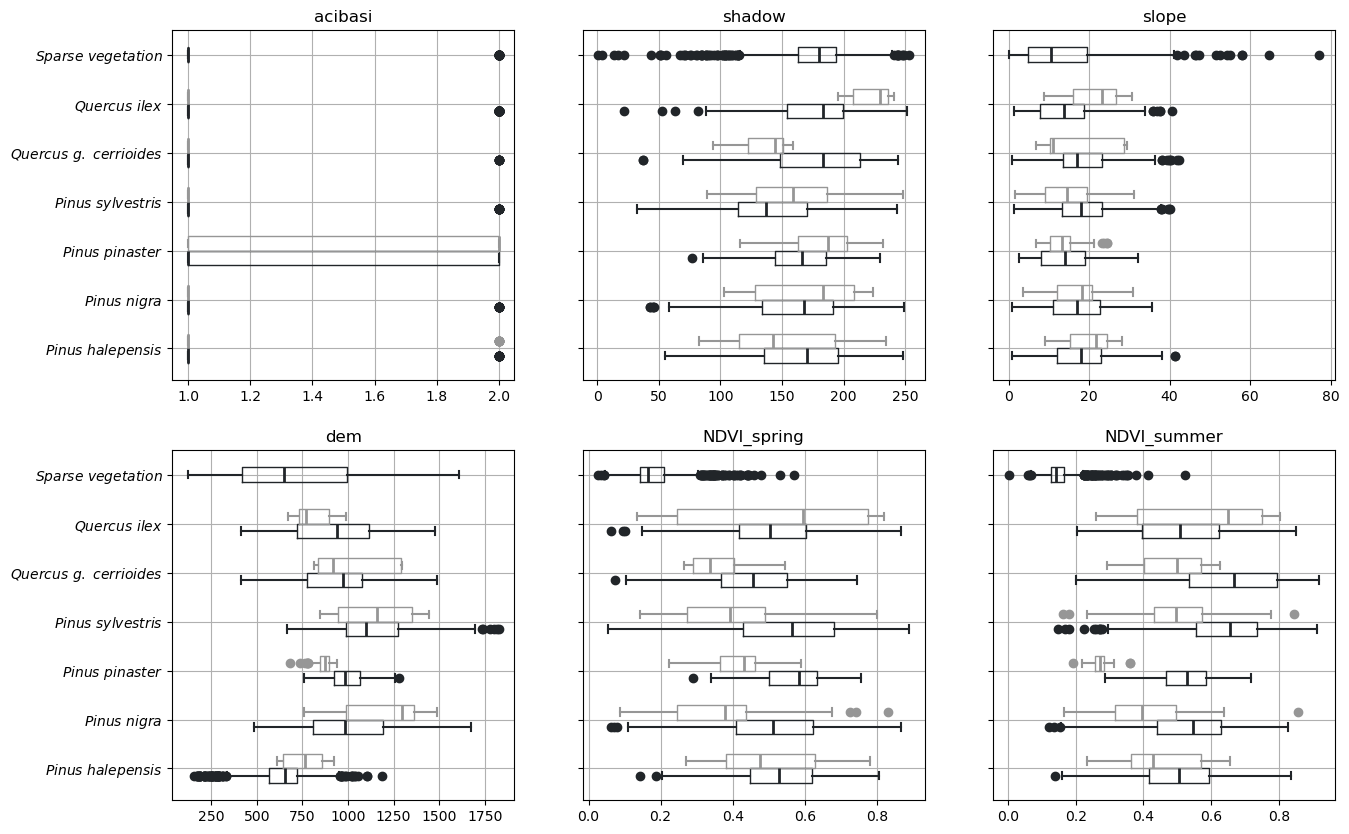

In [59]:
create_boxplot(dat_without_out.query(dat_queries[2]), bbox_vars, ncols, nrows)

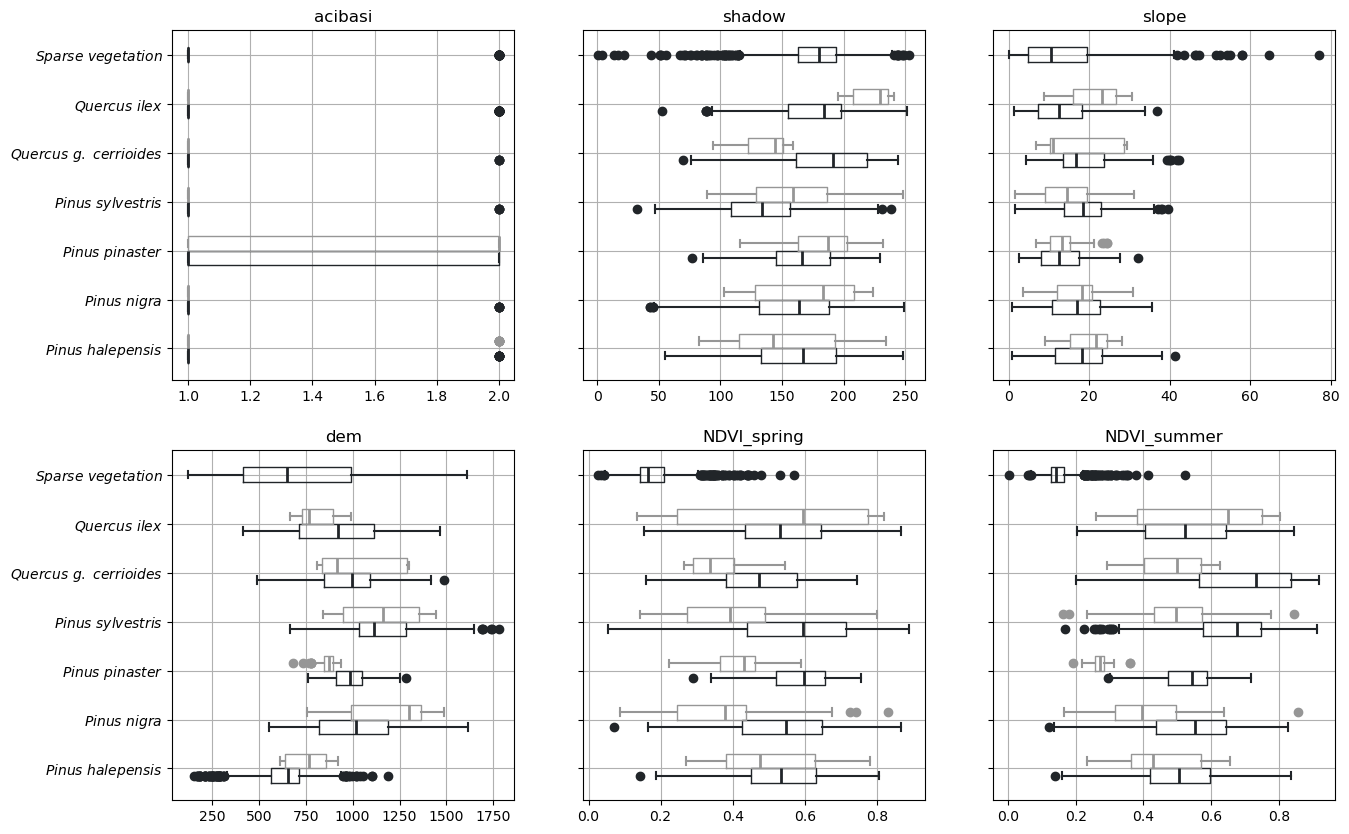

In [60]:
create_boxplot(dat_without_out.query(dat_queries[3]), bbox_vars, ncols, nrows)

#### Construct PCA from summer and spring variables

In [98]:
def reduction(df, columns, suffix):

    # Standardize predictors (mean=0, variance=1) before PCA
    X = StandardScaler().fit_transform(df[columns])

    # Fit PCA with 3 components
    pca = PCA(n_components=3, random_state=42)
    pca.fit(X)

    # Apply PCA transformation to predictors (NumPy array)
    pca_np = pca.transform(X)

    # Create readable names for PCA components
    pca_cols = ['PCA%i' % i for i in range(1, pca.n_components_ + 1)]
    pca_cols = [n + '_' + suffix for n in pca_cols]

    # Convert PCA results into a DataFrame with proper column names
    return pd.DataFrame(pca_np, columns=pca_cols, index=df.index)

version = 2
spring_pcas = reduction(
    dat_without_out.query(dat_queries[version]),
    dat.columns[dat.columns.str.endswith("spring")],
    "spring")
summer_pcas = reduction(
    dat_without_out.query(dat_queries[version]),
    dat.columns[dat.columns.str.endswith("summer")],
    "summer")
global_pcas = reduction(
    dat_without_out.query(dat_queries[version]),
    ["shadow", "dem", "slope"],
    "global")

pcas_df = pd.concat([
    spring_pcas,
    summer_pcas,
    global_pcas,
    dat_without_out.query(dat_queries[version])["code_v1_reclass"]], axis=1)

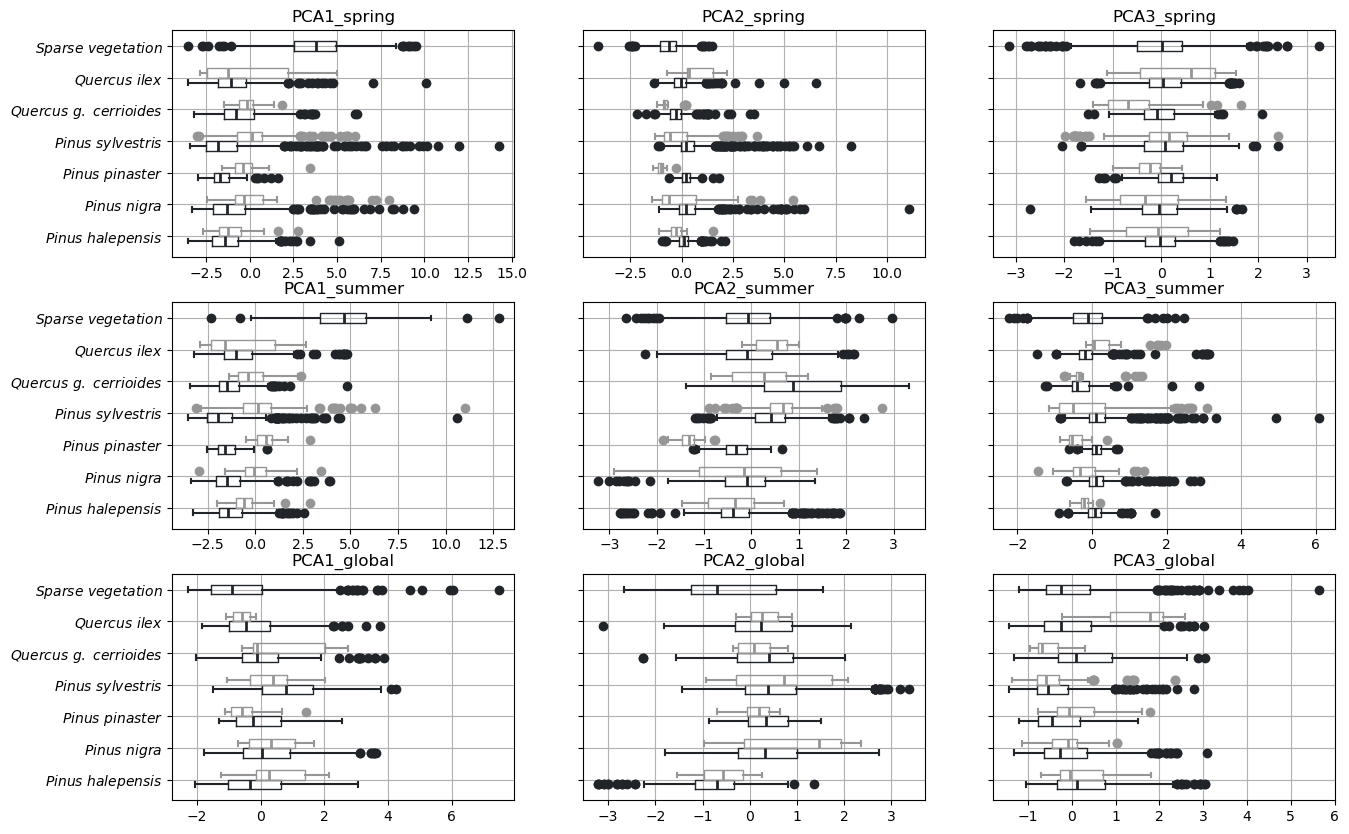

In [99]:
create_boxplot(
    pcas_df,
    pcas_df.columns[pcas_df.columns.str.startswith("PCA")], 3, 3)

## Collinearity Among Predictor Variables

The correlation between variables was calculated using the `corr` method in pandas.

It was also tested with [SciPy using permutations](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html), but this approach required considerably more computation time.

> Although the calculation of the p-value does not make strong assumptions about the distributions underlying the samples, it is only accurate for very large samples (>500 observations). For smaller sample sizes, consider using a permutation test.

[^1]: [Visualization of correlation](https://realpython.com/numpy-scipy-pandas-correlation-python/#visualization-of-correlation)  
[^2]: [Detecting Multicollinearity with VIF](https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/)  
[^3]: [How to Test Multicollinearity](https://www.statology.org/multicollinearity-in-python/)  
[^4]: [Plot Correlation Matrix Using pandas](https://stackoverflow.com/a/50703596/23551600)  


In [ ]:
corr_cols = (
    dat.columns.str.endswith("summer")
    | dat.columns.str.endswith("spring")
    | dat.columns.isin(["shadow", "slope", "dem"])
)
corr = (dat_without_out
    .query(dat_queries[3])
    .loc[:, corr_cols]
    .corr(method='spearman')
)
corr.style.background_gradient(
    cmap='coolwarm',
    vmin=-1,
    vmax=1).format(precision=2)

,coastal_summer,blue_summer,green_summer,red_summer,nir_summer,swir1_summer,swir2_summer,coastal_spring,blue_spring,green_spring,red_spring,nir_spring,swir1_spring,swir2_spring,dem,shadow,slope,NDVI_summer,NDVI_spring
coastal_summer,1.00,0.98,0.94,0.93,0.55,0.83,0.84,0.63,0.66,0.69,0.72,0.49,0.69,0.71,-0.23,0.12,-0.22,-0.89,-0.74
blue_summer,0.98,1.00,0.97,0.96,0.57,0.85,0.86,0.64,0.68,0.72,0.75,0.50,0.71,0.73,-0.25,0.13,-0.22,-0.91,-0.76
green_summer,0.94,0.97,1.00,0.98,0.62,0.90,0.90,0.66,0.70,0.76,0.79,0.54,0.76,0.78,-0.28,0.15,-0.24,-0.91,-0.79
red_summer,0.93,0.96,0.98,1.00,0.56,0.93,0.94,0.67,0.70,0.76,0.80,0.53,0.79,0.81,-0.26,0.17,-0.27,-0.96,-0.81
nir_summer,0.55,0.57,0.62,0.56,1.00,0.65,0.54,0.46,0.50,0.55,0.59,0.68,0.63,0.60,-0.08,0.12,-0.19,-0.36,-0.50
swir1_summer,0.83,0.85,0.90,0.93,0.65,1.00,0.98,0.65,0.68,0.75,0.81,0.55,0.87,0.88,-0.20,0.24,-0.29,-0.86,-0.80
swir2_summer,0.84,0.86,0.90,0.94,0.54,0.98,1.00,0.65,0.68,0.74,0.79,0.51,0.84,0.86,-0.22,0.24,-0.29,-0.91,-0.80
coastal_spring,0.63,0.64,0.66,0.67,0.46,0.65,0.65,1.00,0.96,0.92,0.89,0.67,0.74,0.74,-0.24,0.12,-0.21,-0.64,-0.85
blue_spring,0.66,0.68,0.70,0.70,0.50,0.68,0.68,0.96,1.00,0.96,0.93,0.70,0.77,0.77,-0.24,0.14,-0.22,-0.66,-0.89
green_spring,0.69,0.72,0.76,0.76,0.55,0.75,0.74,0.92,0.96,1.00,0.98,0.75,0.85,0.84,-0.25,0.18,-0.24,-0.70,-0.91


In [97]:
pcas_df.corr(method="spearman").style.background_gradient(
    cmap='coolwarm',
    vmin=-1,
    vmax=1).format(precision=2)

,PCA1_spring,PCA2_spring,PCA3_spring,PCA1_summer,PCA2_summer,PCA3_summer,PCA1_global,PCA2_global,PCA3_global,code_v1_reclass
PCA1_spring,1.00,-0.29,0.15,0.86,0.04,-0.17,-0.42,0.07,0.03,0.81
PCA2_spring,-0.29,1.00,-0.12,-0.35,-0.20,0.69,0.20,0.23,-0.03,-0.41
PCA3_spring,0.15,-0.12,1.00,0.15,0.52,-0.00,0.14,0.02,0.01,0.22
PCA1_summer,0.86,-0.35,0.15,1.00,0.06,-0.08,-0.46,0.10,0.04,0.84
PCA2_summer,0.04,-0.20,0.52,0.06,1.00,0.00,-0.03,0.11,0.15,0.15
PCA3_summer,-0.17,0.69,-0.00,-0.08,0.00,1.00,0.13,0.27,0.01,-0.20
PCA1_global,-0.42,0.20,0.14,-0.46,-0.03,0.13,1.00,-0.01,-0.04,-0.46
PCA2_global,0.07,0.23,0.02,0.10,0.11,0.27,-0.01,1.00,0.11,0.01
PCA3_global,0.03,-0.03,0.01,0.04,0.15,0.01,-0.04,0.11,1.00,0.04
code_v1_reclass,0.81,-0.41,0.22,0.84,0.15,-0.20,-0.46,0.01,0.04,1.00


In [135]:
pd.concat([
    spring_pcas,
    summer_pcas,
    dat_without_out[["dem", "slope", "shadow"]]
], axis=1).corr(method="spearman").style.background_gradient(
    cmap='coolwarm',
    vmin=-1,
    vmax=1).format(precision=2)

,PCA1_spring,PCA2_spring,PCA3_spring,PCA1_summer,PCA2_summer,PCA3_summer,dem,slope,shadow
PCA1_spring,1.00,-0.31,-0.21,0.74,-0.05,-0.25,-0.19,-0.24,0.18
PCA2_spring,-0.31,1.00,0.11,-0.54,0.19,0.52,-0.00,0.15,-0.20
PCA3_spring,-0.21,0.11,1.00,-0.21,0.51,-0.03,-0.04,-0.08,0.04
PCA1_summer,0.74,-0.54,-0.21,1.00,-0.20,-0.15,-0.19,-0.26,0.15
PCA2_summer,-0.05,0.19,0.51,-0.20,1.00,-0.03,0.06,0.03,-0.04
PCA3_summer,-0.25,0.52,-0.03,-0.15,-0.03,1.00,-0.12,0.15,-0.21
dem,-0.19,-0.00,-0.04,-0.19,0.06,-0.12,1.00,0.12,-0.04
slope,-0.24,0.15,-0.08,-0.26,0.03,0.15,0.12,1.00,-0.25
shadow,0.18,-0.20,0.04,0.15,-0.04,-0.21,-0.04,-0.25,1.00


### Variance Inflation Factor

> [...] sequentially drop the covariate with the highest VIF, recalculate the VIFs and repeat this process until all VIFs are smaller than a pre-selected threshold. Montgomery & Peck (1992) used a value of 10, but a more stringent approach is to use values as low as 3 as we did here. High, or even moderate, collinearity is especially problematic when ecological signals are weak. In that case, even a VIF of 2 may cause nonsignificant parameter estimates, compared to the situation without collinearity.



https://stackoverflow.com/q/42658379/23551600

In [117]:
def compute_vifs(df):
    return pd.Series(np.linalg.inv(df.to_numpy()).diagonal(), 
                 index=df.columns, 
                 name='VIF')

def best_predictors(df, dat_query, threshold = 3):
    """Remove variables with the highest VIF one by one until anyone are higher than threshold"""
    corr_cols = (
        df.columns.str.endswith("summer")
        | df.columns.str.endswith("spring")
        | df.columns.isin(["shadow", "slope", "dem"])
    )

    corr = df.query(dat_query).loc[:, corr_cols].corr(method='spearman')
    # Compute VIFs for the first time
    vif = compute_vifs(corr)

    # Create a copy of the dataframe to remove invalid variables
    new_df = corr.copy()

    while vif.max() > threshold:
        # Remove the predictor with the maximum value
        max_vif_idx = vif.idxmax()
        new_df = new_df.drop(max_vif_idx).drop(max_vif_idx, axis=1)
        # Recompute vif values
        vif = compute_vifs(new_df)

    return vif

In [118]:
print(best_predictors(dat_without_out, dat_queries[1]))

nir_summer     2.556488
nir_spring     2.875733
dem            1.139037
shadow         1.147472
slope          1.256244
NDVI_spring    1.682326
Name: VIF, dtype: float64


In [119]:
print(best_predictors(dat_without_out, dat_queries[2]))

coastal_summer    1.852586
nir_summer        2.124803
coastal_spring    2.421040
nir_spring        2.903401
dem               1.069861
shadow            1.096206
slope             1.157478
Name: VIF, dtype: float64


In [120]:
print(best_predictors(dat_without_out, dat_queries[3]))

coastal_summer    2.189474
nir_summer        1.648815
coastal_spring    1.886665
dem               1.104115
shadow            1.087349
slope             1.154844
Name: VIF, dtype: float64
